# Iterative solves for Laplacian smoothing




In [1]:
import numpy as np
import scipy.sparse as sparse
from scipy.io import mmread
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy.sparse.csgraph as graph
import scipy.sparse.linalg as linalg

Function to read the matrix entries from an input file. Matrices are easy to construct in "coordinate format" (COO), but generally we want a "compressed sparse X" for efficient algorithms on matrices. This function returns a compressed sparse row (CSR) matrix. 

In [2]:
def read_vcl_matrix_file(fileName):
    df = pd.read_csv(fileName,header=None,skiprows=1,sep='\t')
    df2 = pd.DataFrame(df[0]).applymap(lambda x: x.strip())
    N = len(df2[0])
    i = np.zeros(N)
    j = np.zeros(N)
    val = np.ones(N)
    for ii in range(N):
        i[ii] = np.int64(re.findall('(\d+), (\d+)',df2[0][ii])[0][0])
        j[ii] = np.int64(re.findall('(\d+), (\d+)',df2[0][ii])[0][1])
        val[ii] = np.float(df[1][ii])
    A = sparse.coo_matrix((val,(i,j)),shape=(int(i[-1]+1),int(i[-1]+1)))
    return sparse.csr_matrix(A)

## Data download for Google Colab

Only execute this repo clone and dir change if running in Google Colab. If running on your own jupyter notebook env, you can skip ahead to "High resolution discretization"

In [ ]:
! git clone https://github.com/uofs-simlab/Math313.git

In [ ]:
% cd Math313/20201013_iterative_solves_laplacian_smoothing

## High resolution discretization

Note that there are only 4 (at max) entries in any row. It's just the sheer scale of this thing that makes it look more dense than that.

The matrix in `highRes_mat.out` is a finite volume discretization of $\left(I-\nabla^2\right)$

In [3]:
%%time 
A = read_vcl_matrix_file('highRes_mat.out')
print(A)

  (0, 0)	171224.0
  (0, 7068)	-1525.9
  (0, 43386)	-1102.46
  (0, 174684)	-1490.8
  (1, 1)	161072.0
  (1, 8431)	-1149.63
  (1, 167438)	-1727.24
  (1, 189836)	-1397.32
  (2, 2)	83256.6
  (2, 97796)	-1533.45
  (2, 172627)	-1866.44
  (2, 190840)	-1232.15
  (3, 3)	3929770.0
  (3, 77168)	-1633.32
  (3, 84949)	-1312.12
  (3, 119146)	-2097.26
  (4, 4)	182836.0
  (4, 40946)	-1332.46
  (4, 41959)	-1127.93
  (4, 181582)	-1595.68
  (5, 5)	127310.0
  (5, 43188)	-1291.95
  (5, 109305)	-1573.54
  (5, 148494)	-1169.11
  (6, 6)	76393.1
  :	:
  (211407, 139897)	-1463.44
  (211407, 206144)	-1259.92
  (211407, 211407)	12654.2
  (211408, 122975)	-1385.46
  (211408, 183063)	-1125.35
  (211408, 211408)	3950.73
  (211409, 206829)	-1948.37
  (211409, 209838)	-878.166
  (211409, 210444)	-912.837
  (211409, 211409)	4246.23
  (211410, 122971)	-1420.71
  (211410, 200499)	-1563.91
  (211410, 207517)	-1295.94
  (211410, 211410)	696152.0
  (211411, 122698)	-1724.33
  (211411, 123029)	-1399.56
  (211411, 200539)	-144

A function to quickly visualize the sparsity structure of matrices.

In [4]:
def visualize_mat(A, figsize=(9,8), dpi=80, facecolor=None, edgecolor='k', markersize=0.05, title="", fontsize=32, ticklabelsize=24):
    fig=plt.figure(figsize=figsize, dpi=dpi, facecolor=facecolor, edgecolor=edgecolor)
    plot=fig.add_subplot(111)
    plot.spy(A,markersize=markersize)
    Nnz = A.nnz
    Nrow = A.shape[0]
    ratio = Nnz/(Nrow*Nrow)
    plt.title(title, fontsize=fontsize)
    plt.xlabel("Number of non-zeros: " + str(Nnz) + " (%.3f %%)" %(ratio*100),fontsize=fontsize)
    plot.tick_params(axis='both', which='major', labelsize=ticklabelsize)

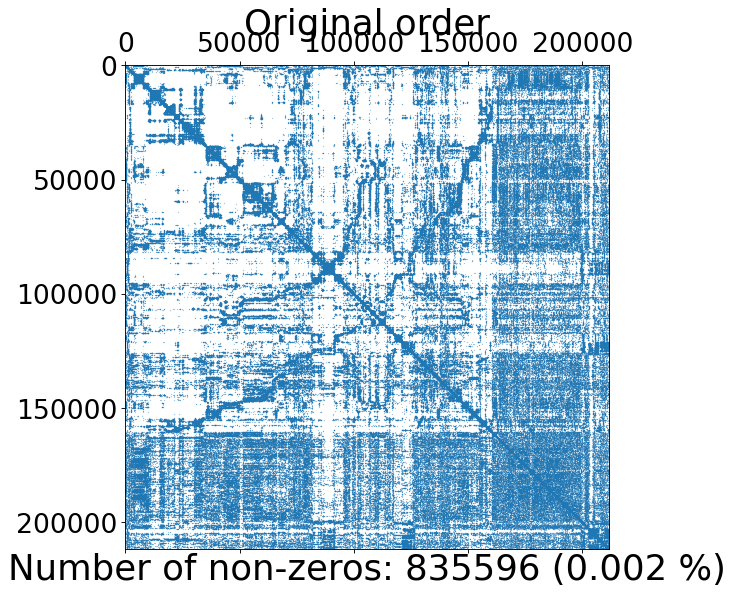

In [5]:
visualize_mat(A,title="Original order",markersize=0.1)

### Reordering the matrix

We can reorder this matrix easily using `scipy`. The reverse Cuthill--McKee (RCM) algorithm orders entries to minimize the bandwidth of the input matrix. The output is a permutation of the input indices. The permuted matrix can be obtained by symmetrically permuting the rows and columns of the original matrix.

In [6]:
Aperm_indices = graph.reverse_cuthill_mckee(A,symmetric_mode=True)
Aperm = A[Aperm_indices,:][:,Aperm_indices]

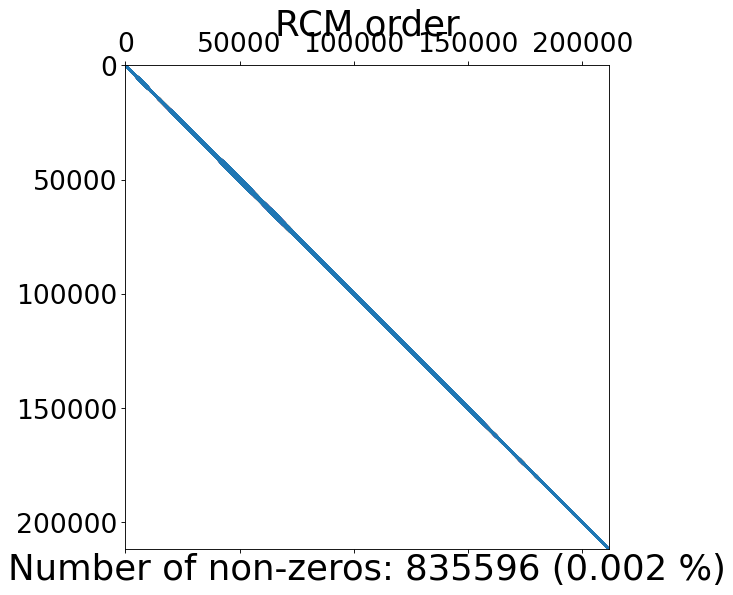

In [16]:
visualize_mat(Aperm,markersize=0.01,title="RCM order")

Compute the matrix bandwidth to compare the different orderings. First, write a function that can do this for the CSR storage format.

In [8]:
def compute_bandwidth_CSR(A):
    """Compute the maximum bandwidth from a CSR sparse matrix A"""
    assert(sparse.isspmatrix_csr(A))
    indices = A.indices
    indptr = A.indptr
    bandwidth = 0
    for row in range(A.shape[0]):
        maxind = np.max(indices[indptr[row]:indptr[row+1]])
        if maxind-row > bandwidth:
            bandwidth = maxind-row
    return bandwidth

In [9]:
print("Bandwidth of original ordering: " + str(compute_bandwidth_CSR(A)))
print("Bandwidth of RCM      ordering: " + str(compute_bandwidth_CSR(Aperm)))

Bandwidth of original ordering: 210855
Bandwidth of RCM      ordering: 1320


### Minimum fill-in ordering

We can produce less fill-in of matrix factors by by using algorithms specifically designed to order unkowns in such a way as to minimize the amount of fill-in. Such methods are usually based around nested dissection (ND).

In `scipy`, this functionality is built into the `linalg.splu` function, and is in fact its default behaviour. Because of this, we start by looking at the factor before we look at the entire matrix.

Notice, in particular, how much faster this factorization is produced than even the RCM ordering.

In [12]:
%%time
Apermcsc = sparse.csc_matrix(Aperm) 
LUpermBEST = linalg.splu(Apermcsc)
A_nd = Aperm[:,LUpermBEST.perm_c][LUpermBEST.perm_c,:]

CPU times: user 7.83 s, sys: 8.21 s, total: 16 s
Wall time: 2.25 s


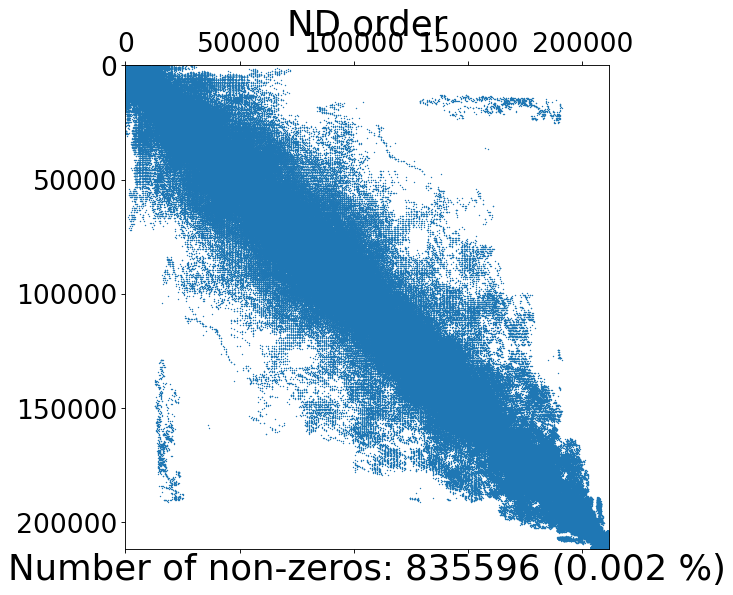

In [15]:
visualize_mat(A_nd,markersize=0.3,title="ND order")

The resulting bandwidth of this ordering is higher than with the RCM ordering, however, we will now show that this is not a bad thing for apply sparse direct solve

In [18]:
print("Bandwidth of ND       ordering: " + str(compute_bandwidth_CSR(A_nd)))

Bandwidth of ND       ordering: 173136


## Solve times

In [19]:
u_star = np.ones(A.shape[0])
b_orig = A*u_star
b_perm = b_orig[Aperm_indices]

# Iterative solves

In the above direct solves, the time to solution for a given order can be taken as the sum of the factorization time and the solve time. From this view, the fill-in minimizing ordering comes out way ahead of the other orderings.

Now when we consider iterative solving techniques, we will show that the ordering does not play a significant role in the time to solution. Minor improvements in the time to solution can be observed upon changing the ordering, but this is nowhere near the improvements that can be found by changing the iterative algorithm (and preconditioner).

We first set the desired tolerance and gmres restart amounts.

In [20]:
tolerance=1e-14
restarts=100

## GMRES

Generalized Minimum RESidual (GMRES) is an iterative algorithm for solving general sparse matrix equations. We first look at this method applied to the different orderings.

To monitor residuals throughout the iterations, we define a simple callback function.

In [21]:
class gmres_counter(object):
    """Counter for GMRES solves. Note, this appends residuals to a global `residuals` list."""
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        print("GMRES Residuals:")
    def __call__(self, rk=None):
        residuals.append(rk)
        self.niter += 1
        if self._disp:
            print("  step %d, residual %s" %(self.niter,str(rk)))

For timing, we do not use the callback function because it adds overhead. The following cells compute solutions via GMRES with no preconditioning.

Original ordering

In [22]:
%%time 
u_gmres_orig, info = linalg.gmres(A,b_orig,tol=tolerance,restart=restarts)

CPU times: user 20min 28s, sys: 9min 56s, total: 30min 25s
Wall time: 3min 55s


RCM ordering.

In [23]:
%%time 
u_gmres_perm, info = linalg.gmres(Aperm,b_perm,tol=tolerance,restart=restarts)

CPU times: user 21min 14s, sys: 8min 46s, total: 30min 1s
Wall time: 3min 56s


ND ordering (note we now need a permuted RHS vector)

In [24]:
b_nd = b_perm[LUpermBEST.perm_c]

In [25]:
%%time 
u_gmres_nd, info = linalg.gmres(A_nd,b_nd,tol=tolerance,restart=restarts)

CPU times: user 25min 25s, sys: 12min 6s, total: 37min 32s
Wall time: 4min 54s


The residuals for each of the orderings follow a similar path, so we only display a single one.

In [27]:
residuals = []
counter = gmres_counter(disp=False)
u_gmres, info = linalg.gmres(A_nd,b_nd,tol=tolerance,callback=counter,restart=restarts)
gmres_residuals = residuals[:]

GMRES Residuals:


In [28]:
def residual_plot(res,figsize=(9,8), dpi=80, facecolor=None, edgecolor='k', markersize=0.05, title="", fontsize=32, ticklabelsize=24):
    """Plot residuals for iterative method"""
    fig = plt.figure(figsize=figsize,dpi=dpi,facecolor=facecolor,edgecolor=edgecolor)
    plot=fig.add_subplot(111,facecolor=None)
    plot.semilogy(range(1,len(res)+1),res,'x')
    plt.title(title,fontsize=fontsize)
    plt.xlabel("Iteration",fontsize=fontsize)
    plt.ylabel("Residual",fontsize=fontsize)
    plot.tick_params(axis='both', which='major', labelsize=ticklabelsize)

16955

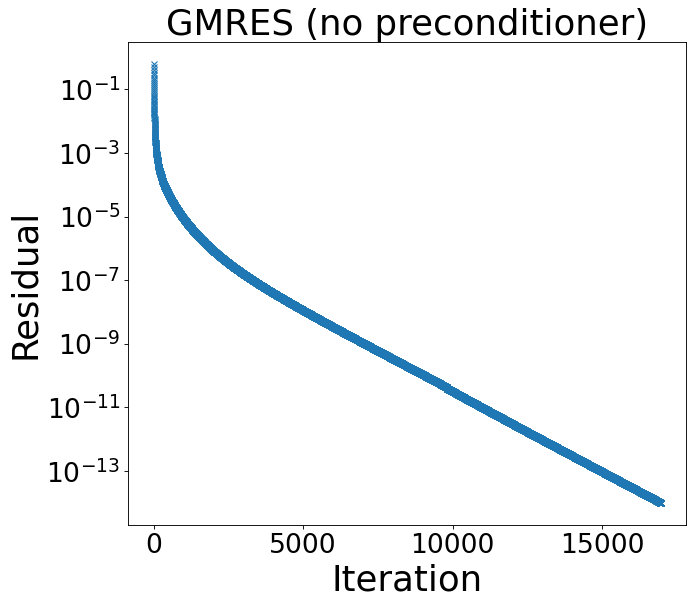

In [29]:
residual_plot(gmres_residuals,title="GMRES (no preconditioner)")
len(gmres_residuals)

In [30]:
print("Error of original order GMRES solve: " + str(np.linalg.norm(u_star-u_gmres_orig)))
print("Error of RCM      order GMRES solve: " + str(np.linalg.norm(u_star-u_gmres_perm)))
print("Error of ND       order GMRES solve: " + str(np.linalg.norm(u_star-u_gmres_nd)))

Error of original order GMRES solve: 2.7385827867061983e-08
Error of RCM      order GMRES solve: 2.743000287190064e-08
Error of ND       order GMRES solve: 2.7816968839026458e-08


## Conjugate gradient

Since we are dealing with a positive definite system, we can also solve it with conjugate gradient (CG) iteration. 

Note that the callback function for CG is different from that of GMRES. Since its `__call__` function exposes the solution at the current iteration, we must compute the residual manually.

In [31]:
class cg_counter(object):
    def __init__(self, A, b, disp=True):
        self.A = A
        self.b = b
        self.normalization=np.linalg.norm(b)
        self._disp = disp
        self.niter = 0
        print("Residuals:")
    def __call__(self, xk=None):
        res = np.linalg.norm(self.A*xk-self.b)/self.normalization
        residuals.append(res)
        self.niter += 1
        if self._disp:
            print("  step %d, residual %s" %(self.niter,str(res)))

Original ordering.

In [32]:
%%time
u_cg_orig, info = linalg.cg(A,b_orig,tol=tolerance)

CPU times: user 2min 58s, sys: 4min 29s, total: 7min 28s
Wall time: 56.8 s


RCM ordering.

In [33]:
%%time
u_cg_perm, info = linalg.cg(Aperm,b_perm,tol=tolerance)

CPU times: user 1min 58s, sys: 2min 56s, total: 4min 55s
Wall time: 37.9 s


ND ordering

In [35]:
%%time
u_cg_nd, info = linalg.cg(A_nd,b_nd,tol=tolerance)

CPU times: user 2min 55s, sys: 4min 22s, total: 7min 18s
Wall time: 55.1 s


Again, the residual progression throughout the algorithm is very similar regardless of the ordering, so we only show a single one.

In [36]:
residuals = []
counter = cg_counter(Aperm,b_perm,disp=False)
u_cg, info = linalg.cg(Aperm,b_perm,tol=tolerance,callback=counter)
cg_residuals = residuals[:]

Residuals:


5158

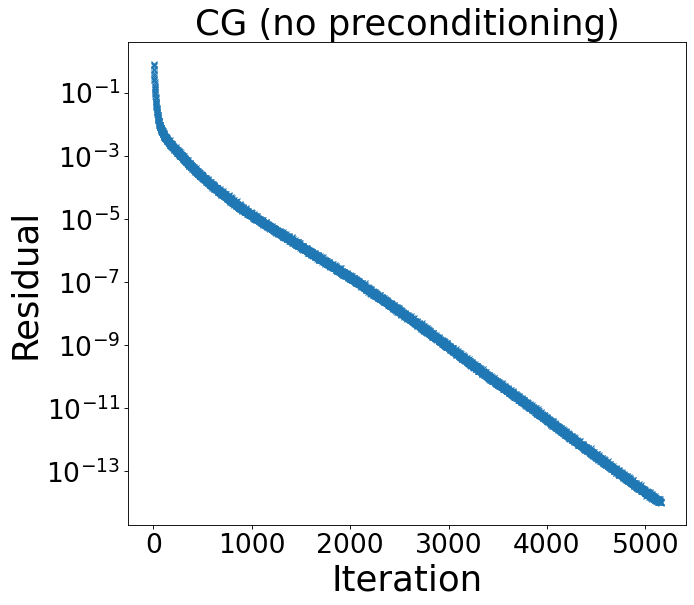

In [37]:
residual_plot(cg_residuals,title="CG (no preconditioning)")
len(cg_residuals)

In [38]:
print("Error of original order CG solve: " + str(np.linalg.norm(u_star-u_cg_orig)))
print("Error of RCM      order CG solve: " + str(np.linalg.norm(u_star-u_cg_perm)))
print("Error of ND       order CG solve: " + str(np.linalg.norm(u_star-u_cg_nd)))

Error of original order CG solve: 7.842589403102002e-10
Error of RCM      order CG solve: 7.792342961152119e-10
Error of ND       order CG solve: 7.918915124195004e-10


# Preconditioning

Unpreconditioned iterative methods are generally a bad idea, and the performance above demonstrates this. 

We precondition using incomplete LU (ILU) with thresholding, using the default drop tolerance of $10^{-4}$.

Generate a (left) preconditioning operator for original ordering.

(Note this can be used for both GMRES and CG)

In [39]:
%%time
M_orig_inv=linalg.spilu(Acsc)
M_orig = linalg.LinearOperator(A.shape,M_orig_inv.solve)

CPU times: user 630 ms, sys: 28 ms, total: 658 ms
Wall time: 660 ms


GMRES + ILU with original order.

In [40]:
%%time 
u_gmres_orig_precond, info = linalg.gmres(A,b_orig,tol=tolerance,M=M_orig,restart=restarts)

CPU times: user 1.41 s, sys: 1.53 s, total: 2.93 s
Wall time: 412 ms


Generate (left) preconditioning operator for RCM ordering.

(Note again can be used for GMRES and CG)

In [41]:
%%time
M_perm_inv=linalg.spilu(Apermcsc)
M_perm = linalg.LinearOperator(A.shape,M_perm_inv.solve)

CPU times: user 547 ms, sys: 24.5 ms, total: 572 ms
Wall time: 569 ms


GMRES + ILU with RCM order

In [42]:
%%time 
u_gmres_perm_precond, info = linalg.gmres(Aperm,b_perm,tol=tolerance,M=M_perm,restart=restarts)

CPU times: user 1.31 s, sys: 1.36 s, total: 2.66 s
Wall time: 386 ms


In [44]:
Andcsc = sparse.csc_matrix(A_nd) # produce a CSC format version of the ND ordered matrix

Generate a (left) preconditioning operator for the ND order.

In [45]:
%%time
M_nd_inv=linalg.spilu(Andcsc)
M_nd = linalg.LinearOperator(A.shape,M_nd_inv.solve)

CPU times: user 640 ms, sys: 40.6 ms, total: 681 ms
Wall time: 679 ms


GMRES + ILU with ND order.

In [47]:
%%time 
u_gmres_nd_precond, info = linalg.gmres(A_nd,b_nd,tol=tolerance,M=M_nd,restart=restarts)

CPU times: user 1.25 s, sys: 1.35 s, total: 2.6 s
Wall time: 381 ms


Plot residual progression for a run of GMRES + ILU.

In [49]:
residuals = []
counter = gmres_counter(disp=False)
u_gmres, info = linalg.gmres(A_nd,b_nd,tol=tolerance,M=M_nd,callback=counter,restart=restarts)
gmres_precond_residuals = residuals[:]

GMRES Residuals:


4

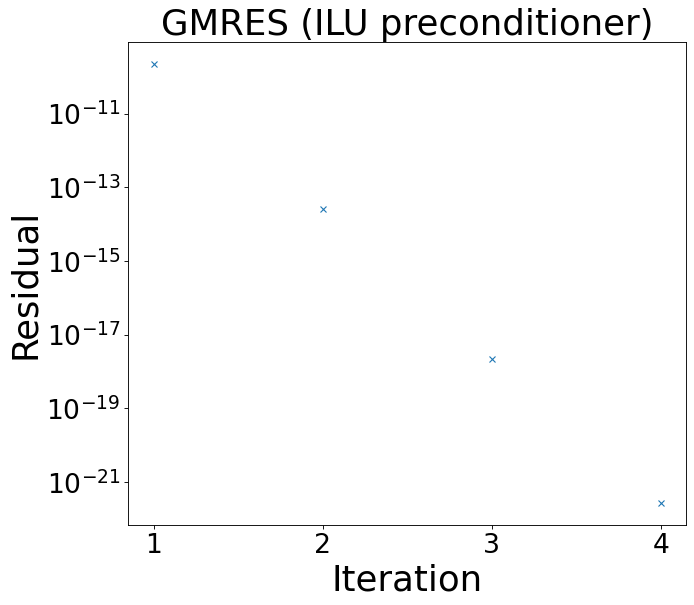

In [50]:
residual_plot(gmres_precond_residuals,title="GMRES (ILU preconditioner)")
len(gmres_precond_residuals)

In [51]:
print("Error of original order GMRES solve: " + str(np.linalg.norm(u_star-u_gmres_orig_precond)))
print("Error of RCM      order GMRES solve: " + str(np.linalg.norm(u_star-u_gmres_perm_precond)))
print("Error of ND       order GMRES solve: " + str(np.linalg.norm(u_star-u_gmres_nd_precond)))

Error of original order GMRES solve: 1.4496719873188207e-13
Error of RCM      order GMRES solve: 1.8043392278625424e-13
Error of ND       order GMRES solve: 1.5123246786255303e-13


Since the preconditioning operators were already defined above, simply run CG + ILU for each of the orderings.

In [52]:
%%time 
u_cg_orig_precond, info = linalg.cg(A,b_orig,tol=tolerance,M=M_orig)

CPU times: user 1.14 s, sys: 1.41 s, total: 2.55 s
Wall time: 348 ms


In [53]:
%%time 
u_cg_perm_precond, info = linalg.cg(Aperm,b_perm,tol=tolerance,M=M_perm)

CPU times: user 1.17 s, sys: 1.55 s, total: 2.72 s
Wall time: 369 ms


In [55]:
%%time 
u_cg_nd_precond, info = linalg.cg(A_nd,b_nd,tol=tolerance,M=M_nd)

CPU times: user 934 ms, sys: 1.32 s, total: 2.26 s
Wall time: 365 ms


In [ ]:
residuals = []
counter = cg_counter(Aperm,b_perm,disp=False)
u_cg, info = linalg.cg(Aperm,b_perm,tol=tolerance,Mcallback=counter)
cg_residuals = residuals[:]

In [56]:
print("Error of original order CG solve: " + str(np.linalg.norm(u_star-u_cg_orig_precond)))
print("Error of RCM      order CG solve: " + str(np.linalg.norm(u_star-u_cg_perm_precond)))
print("Error of ND       order CG solve: " + str(np.linalg.norm(u_star-u_cg_nd_precond)))

Error of original order CG solve: 1.233425802323154e-13
Error of RCM      order CG solve: 1.2144916359816105e-13
Error of ND       order CG solve: 1.0834366099270325e-13
